In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# loading data
train_df = pd.read_csv('DATASETS/train.csv', low_memory=False)
store_df = pd.read_csv('DATASETS/store.csv', low_memory=False)

In [4]:
# merging the data and displaying starting types of all column data
df = pd.merge(train_df, store_df, on='Store', how='left')
df.dtypes

Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [5]:
# getting number of rows and columns
print(f"Rows: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

Rows: 1017209
Columns: 18


In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
# label encode all the following columns
cols = ['StateHoliday', 'StoreType', 'Assortment', 'PromoInterval']
for col in cols:
    df[col] = df[col].astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])

In [8]:
# converting string numbers into just numbers
cols = ['Open', 'Promo', 'Promo2', 'SchoolHoliday']
for col in cols:
    df[col] = df[col].astype(int)

In [9]:
df.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                          int64
SchoolHoliday                         int64
StoreType                             int64
Assortment                            int64
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                         int64
dtype: object

# Hypothesis Testing

## Conclusion 1: Stores with ongoing promotions have higher sales.

**Null (H0)**: The mean sales for stores with Promo = 0 is equal to the mean sales for stores with Promo = 1.

**Alternative (Ha)**: The mean sales for stores with Promo = 1 is greater than that of stores with Promo = 0.

In [21]:
promo_df = df[df["Promo"] == 1]
nopromo_df = df[df["Promo"] == 0]

pval = ttest_ind(promo_df["Sales"], nopromo_df["Sales"], equal_var=False, alternative='greater').pvalue
print(f"P-value = {pval}")

P-value = 0.0


We have found that the p-value is **effectively 0**. There is very strong evidence that sales are higher with promotions compared to without promotions. We are able to reject the null hypothesis. 

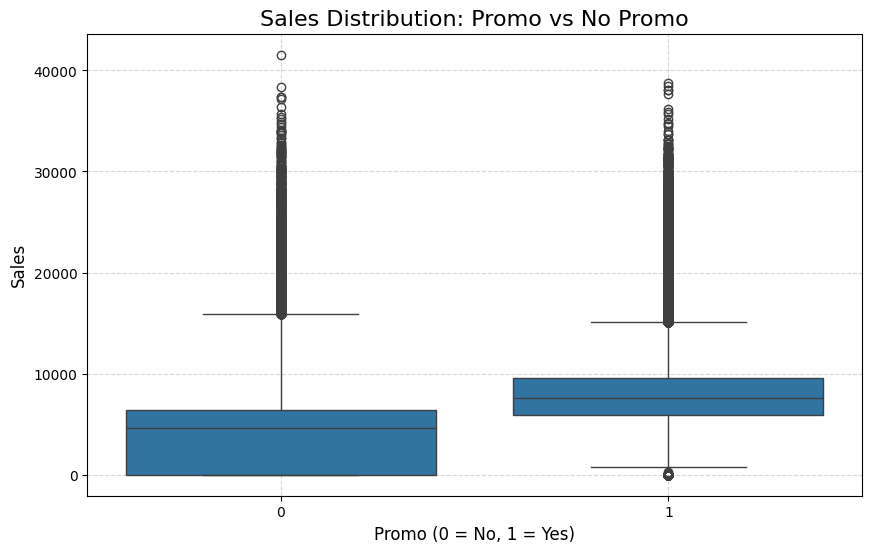

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="Promo", y="Sales", data=df)
plt.title("Sales Distribution: Promo vs No Promo", fontsize=16)
plt.xlabel("Promo (0 = No, 1 = Yes)", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()